In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

In [3]:
# Create oracle function
# i mostly don't have to worry about the logic here since the circuit is the important part and not the oracle function
def dj_query(num_qubits):

    qc = QuantumCircuit(num_qubits + 1)
 
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        # Decides if oracle function is constant 0 or 1
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )
 
    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc
 
    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")
 
    qc.barrier()
 
    return qc

In [4]:
def compile_circuit(function: QuantumCircuit):

    n = function.num_qubits - 1             # -1 is to remove the ancilla qubit from the count
    qc = QuantumCircuit(n + 1, n)           # create a quantum circuit with n+1 qubits and n classical bits
    qc.x(n)                                 # put an x gate on the ancilla qubit to turn it into a 1
    qc.h(range(n + 1))                      # lay out the first hadamard gate layer including on the ancilla qubit to get the minus state for phase kickback
    qc.compose(function, inplace=True)      # puts the oracle function in front of the first hadamard layer
    qc.h(range(n))                          # second layer of hadamard not including the ancilla qubit
    qc.measure(range(n), range(n))          # take the measurements of the qubits and store the measurements in their corresponding classical bits
    return qc

In [ ]:
def dj_algorithm(function: QuantumCircuit):
 
    qc = compile_circuit(function)
 
    result = AerSimulator().run(qc, shots=1, memory=True).result() # this just runs a 1 time simulation at the measurement blocks
    measurements = result.get_memory()

    display(measurements) # when the measurements are all 1 then the function is constant

    if "1" in measurements[0]: # if 1 is found in any of the qubit measurements then the oracle function is balanced
        return "balanced"
    return "constant"

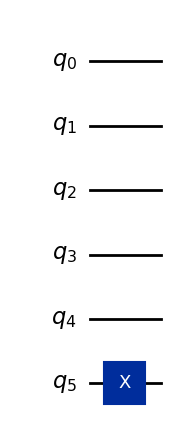

['00000']

'constant'

In [6]:
f = dj_query(5)
display(f.draw("mpl"))
display(dj_algorithm(f))